In [1]:
# To be run after Taiwan-Gender-Data-Prep
%matplotlib inline
# Load all necessary packages
import sys
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from aif360.datasets import BinaryLabelDataset
from aif360.metrics  import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from sklearn.linear_model  import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics       import accuracy_score
from common_utils          import compute_metrics
from IPython.display       import Markdown, display

In [2]:
# Read the cleaned Taiwan-Credit-Card-Cleaned-Marriage dataset
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Marriage.csv')

In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'MARRIAGE'
priv_grp            = 1  # Married males and females 
unpriv_grp          = 0  # Single males and females  
lab                 = 'DEFAULT'
fav_label           = 1 # Will not default next month
unfav_label         = 0 # Will default next month
privileged_groups   = [{protected_attr: priv_grp}]   # Married folk (male and female)
unprivileged_groups = [{protected_attr: unpriv_grp}] # Single folk  (male and female)

In [4]:
X = Taiwan_df.drop("DEFAULT",axis=1)
y = Taiwan_df["DEFAULT"]

In [5]:
# Create a Binary Label Dataset to use with AIF360 APIs
Taiwan_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [6]:
Taiwan_train, Taiwan_vt   = Taiwan_bld.split([0.8], shuffle=True)
Taiwan_valid, Taiwan_test = Taiwan_vt.split([0.5], shuffle=True)

In [7]:
# Metric for the original dataset
metric_train_bld = BinaryLabelDatasetMetric(Taiwan_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print('Base Rate                     :', metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

#### Biased training dataset

Number of instances           : 23698.0
Base Rate                     : 0.7796016541480294
Consistency                   : [0.75086505]
Disparate Impact              : 1.0359059106996362
Mean Difference               : 0.02746094039689384
Statistical Parity Difference : 0.02746094039689384
# of positives(privileged)    : 8357.0
# of positives(non-privileged): 10118.0
Total positive instances"     : 18475.0
# of negatives(privileged)    : 2570.0
# of negatives(non-privileged): 2653.0
Total negative instances"     : 5223.0
Difference in mean outcomes between unprivileged and privileged groups = 0.027461


In [8]:
#Train with and transform the original training data
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(Taiwan_train)
Taiwan_train_lfr = RW.transform(Taiwan_train)

In [9]:
### Testing 
assert np.abs(Taiwan_train_lfr.instance_weights.sum()-Taiwan_train.instance_weights.sum())<1e-6

In [10]:
#Metric with the transformed training data
metric_train_lfr = BinaryLabelDatasetMetric(Taiwan_train_lfr, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Debiased training dataset"))
print('Number of instances           :', metric_train_lfr.num_instances())
print('Base Rate                     :', metric_train_lfr.base_rate())
print('Consistency                   :', metric_train_lfr.consistency())
print('Disparate Impact              :', metric_train_lfr.disparate_impact())
print('Mean Difference               :', metric_train_lfr.mean_difference())
print('Statistical Parity Difference :', metric_train_lfr.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_lfr.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_lfr.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_lfr.num_positives(privileged=True)+metric_train_lfr.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_lfr.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_lfr.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_lfr.num_negatives(privileged=True)+metric_train_lfr.num_negatives(privileged=False))

print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_lfr.mean_difference())

#### Debiased training dataset

Number of instances           : 23698.0
Base Rate                     : 0.7796016541480294
Consistency                   : [0.75086505]
Disparate Impact              : 1.0000000000000002
Mean Difference               : 1.1102230246251565e-16
Statistical Parity Difference : 1.1102230246251565e-16
# of positives(privileged)    : 8518.707274875516
# of positives(non-privileged): 9956.292725124484
Total positive instances"     : 18475.0
# of negatives(privileged)    : 2408.2927251244837
# of negatives(non-privileged): 2814.707274875517
Total negative instances"     : 5223.000000000001
Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [11]:
### Testing 
assert np.abs(metric_train_lfr.mean_difference()) < 1e-6

In [12]:
###Train logistic regression classifier on biased training data

In [13]:
# Logistic regression classifier and predictions
scale_orig = MinMaxScaler()
#scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(Taiwan_train.features)
y_train = Taiwan_train.labels.ravel()
w_train = Taiwan_train.instance_weights.ravel() # All of these will 1's.

lmod = LogisticRegression()
lmod.fit(X_train, y_train, sample_weight=Taiwan_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# determine the protected attribute class index value?
pos_ind = np.where(lmod.classes_ == Taiwan_train.favorable_label)[0][0]

Taiwan_train_pred        = Taiwan_train.copy()
Taiwan_train_pred.labels = y_train_pred

c:\users\befaria\appdata\local\continuum\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [14]:
#Use the trained model to obtain scores for original validation and test sets
Taiwan_valid_pred = Taiwan_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(Taiwan_valid_pred.features)
y_valid = Taiwan_valid_pred.labels
Taiwan_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

Taiwan_test_pred = Taiwan_test.copy(deepcopy=True)
X_test = scale_orig.transform(Taiwan_test_pred.features)
y_test = Taiwan_test_pred.labels
Taiwan_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [15]:
###Determine Best Classification threshold & Best Balancced Accuracy for biased validation data

In [16]:
#Find the biased optimal classification threshold from the validation set

num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = Taiwan_valid_pred.scores > class_thresh
    Taiwan_valid_pred.labels[fav_inds] = Taiwan_valid_pred.favorable_label
    Taiwan_valid_pred.labels[~fav_inds] = Taiwan_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(Taiwan_valid,Taiwan_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Validation data - Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Validation data - Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Validation data - Best balanced accuracy (no reweighing) = 0.6873
Validation data - Optimal classification threshold (no reweighing) = 0.7227


In [17]:
###Use best classification threshold on the biased test data

In [18]:
#Predictions from the original test set at the optimal classification threshold
display(Markdown("#### Predictions from original testing data using best classification threshold"))
bal_acc_arr_orig       = []
disp_imp_arr_orig      = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = Taiwan_test_pred.scores > thresh
    Taiwan_test_pred.labels[fav_inds] = Taiwan_test_pred.favorable_label
    Taiwan_test_pred.labels[~fav_inds]= Taiwan_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(Taiwan_test, Taiwan_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data using best classification threshold

Classification threshold used = 0.7227


 55%|██████████████████████████████████████████████████████████████████                                                      | 55/100 [00:00<00:00, 274.11it/s]

Balanced accuracy = 0.6808
Statistical parity difference = 0.0634
Disparate impact = 1.0848
Average odds difference = 0.0671
Equal opportunity difference = 0.0492
Theil index = 0.1454


 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 79/100 [00:00<00:00, 262.01it/s]c:\users\befaria\appdata\local\continuum\miniconda3\lib\site-packages\aif360\metrics\dataset_metric.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
c:\users\befaria\appdata\local\continuum\miniconda3\lib\site-packages\aif360\metrics\dataset_metric.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 252.17it/s]


Display Disparate Impact v/s Balanced Accuracy for all thresholds


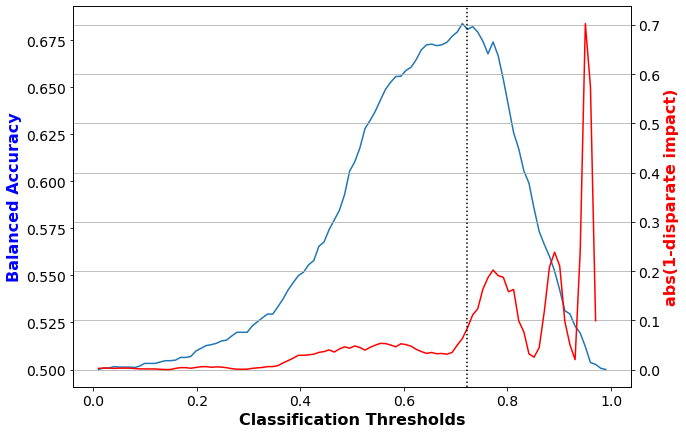

In [19]:
print('Display Disparate Impact v/s Balanced Accuracy for all thresholds')
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [20]:
print('abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.')
print('However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.')

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.


Display Average Odds Difference v/s Balanced Accuracy for all thresholds


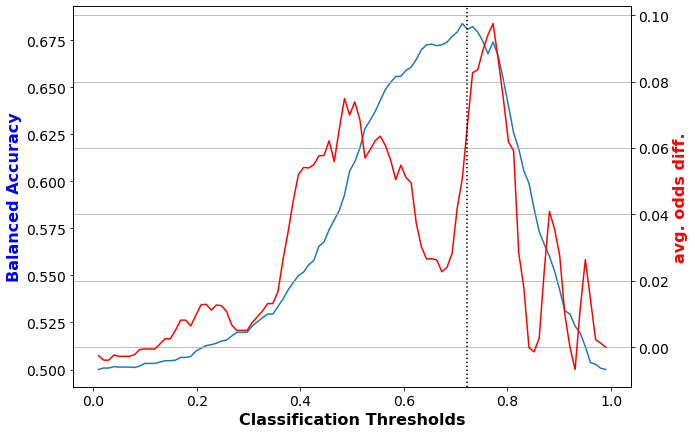

In [21]:
print('Display Average Odds Difference v/s Balanced Accuracy for all thresholds')
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [22]:
print('average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.')
print('However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.')

average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.
However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.


In [23]:
###Now run a logistic regression on debiased Train data

In [24]:
scale_transf = MinMaxScaler()
X_train = scale_transf.fit_transform(Taiwan_train_lfr.features)
y_train = Taiwan_train_lfr.labels.ravel()

lmod = LogisticRegression()
# lmod will be the debiased logistic model
lmod.fit(X_train, y_train,
        sample_weight=Taiwan_train_lfr.instance_weights) # These will be the modified weights
y_train_pred = lmod.predict(X_train)

c:\users\befaria\appdata\local\continuum\miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [25]:
#Obtain scores for transformed test set using the debiased lmod
Taiwan_test_lfr_pred = Taiwan_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(Taiwan_test_lfr_pred.features)
y_test = Taiwan_test_lfr_pred.labels
# lmod is the logistic regression model trained on the debiased data
Taiwan_test_lfr_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [26]:
###Predictions from the transformed test set at the optimal classification threshold

In [27]:
display(Markdown("#### Predictions from transformed testing data"))
balanced_acc_lfr = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = Taiwan_test_lfr_pred.scores > thresh
    Taiwan_test_lfr_pred.labels[fav_inds] = Taiwan_test_lfr_pred.favorable_label
    Taiwan_test_lfr_pred.labels[~fav_inds] = Taiwan_test_lfr_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(Taiwan_test, Taiwan_test_lfr_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    balanced_acc_lfr.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.7227


 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 71/100 [00:00<00:00, 225.36it/s]

Balanced accuracy = 0.6710
Statistical parity difference = 0.0152
Disparate impact = 1.0182
Average odds difference = 0.0115
Equal opportunity difference = 0.0082
Theil index = 0.1026


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 222.72it/s]


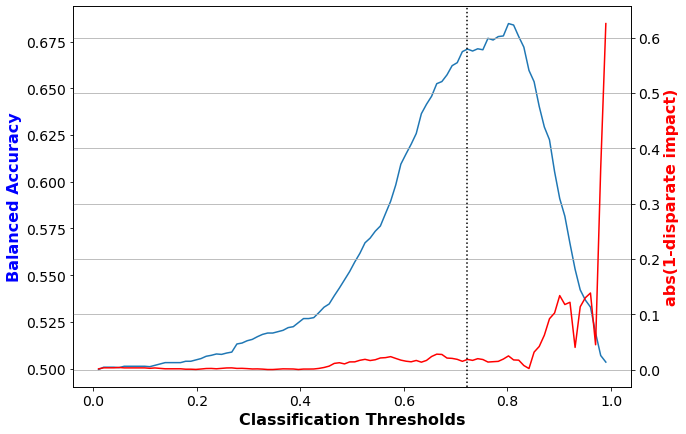

In [28]:
#Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, balanced_acc_lfr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [29]:
print('abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.')
print('For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.')

abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness.


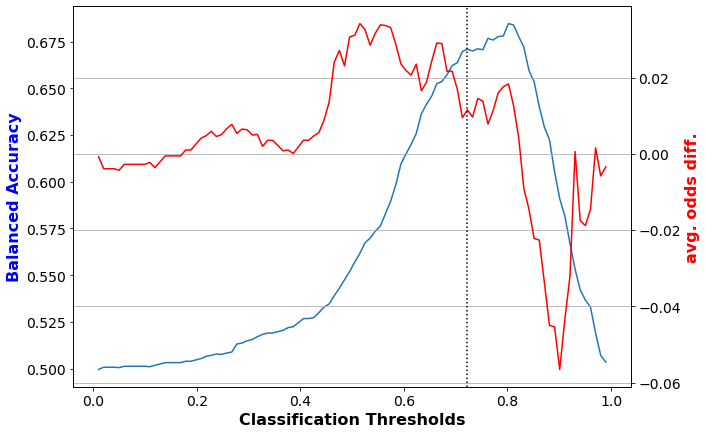

In [30]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, balanced_acc_lfr)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

In [31]:
print('average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.')
print('For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness')

average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv)) must be close to zero for the classifier to be fair.
For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case. This implies fairness
